In [1]:
from mumag3 import *
from magpi.prelude import *
from magpi.calc import divergence, curl, laplace
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton
from magpi.integrate import gauss5, simpson, QuadRule
from matplotlib.ticker import FormatStrFormatter
import numpy as np

jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", False)
%matplotlib widget

key = random.PRNGKey(42)

2024-03-08 10:25:27.389812: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:

from numpy.polynomial.legendre import leggauss

In [8]:
leggauss(2)

(array([-0.57735027,  0.57735027]), array([1., 1.]))

In [2]:
def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2 * k)
    mx = - z / r * sqrt(1 - exp(-4 * k))
    mz = x / r * sqrt(1 - exp(-4 * k))

    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_flower(x):
    mx = x[..., 0] * x[..., 2]
    my = x[..., 1] * x[..., 2]# + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


In [3]:
domain = Cuboid(
    linspace(-0.5, 0.5, 9),
    linspace(-0.5, 0.5, 9),
    linspace(-0.5, 0.5, 9)
)

x_dom = array(Halton(3, seed=124).random(2**13))
x_dom = domain.transform(x_dom)


x_tensor_dom = lax.map(
    lambda x: surface_tensors_grad(x, domain, 15, gauss5), 
    x_dom
)

In [4]:

def create_stray_field_solver(
    X_dom,
    domain,
    W_elm,
    b_elm,
):
    h_elm = lambda x: tanh(W_elm @ (domain.normalize(x)) + b_elm)
    u_elm = lambda x: h_elm(x) * domain.adf(x)
    Q = vmap(lambda x: laplace(u_elm)(x))(X_dom)

    U, S, VT = jax.scipy.linalg.svd(Q, full_matrices=False, lapack_driver="gesvd")
    Pinv = VT.T * (1 / S) @ U.T
    def solve_stray_field(m, *args):
        f = lambda x: -curl(m)(x, *args)
        b1 = vmap(f)(X_dom)
        params_A1 = Pinv @ b1
        A1 = lambda x: u_elm(x) @ params_A1
        A1_without_adf = lambda x: h_elm(x) @ params_A1

        def g(y):
            _m = m(y, *args)
            n = domain.normal_vec(y)
            return jnp.cross(_m, n) + A1_without_adf(y)
        
        c = charges(domain, g)
        curl_A2 = lambda dt: 1 / (4 * pi) * _solve_sufrace_integral(c, dt)
        bs = lambda x, dt: (curl(A1)(x) + curl_A2(dt))# - m_flower(x)
        return bs


    return solve_stray_field

def _solve_sufrace_integral(charges, target) -> Array:
    def _dot_sum(a, b):
        return jnp.sum(-jnp.cross(a, b), axis=(0,1,2))

    face_contributions = tree_map(lambda c, t: _dot_sum(c, t), charges, target)
    A2 = jnp.sum(array(face_contributions), axis=0)
    return A2


In [5]:
_weights = array(Halton(4, seed=1362).random(2 ** 10))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2

stray_field_solver = create_stray_field_solver(
    x_dom, domain, W_elm, b_elm,
)

In [6]:
_weights = array(Halton(4, seed=1362).random(2 ** 9))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2

stray_field_solver = create_stray_field_solver(x_dom, domain, W_elm, b_elm,)

class PINN(nn.Module):
    @nn.compact
    def __call__(self, x, lam):
        nodes = 50
        activation = nn.gelu
        y = concatenate([x, lam.ravel()])
        y = activation(nn.Dense(nodes, name="dense1")(y))
        y = activation(nn.Dense(nodes, name="dense2")(y))
        y = activation(nn.Dense(nodes, name="dense3")(y))
        y = activation(nn.Dense(nodes, name="dense4")(y))
        y = activation(nn.Dense(nodes, name="dense5")(y))
        y = activation(nn.Dense(nodes, name="dense6")(y))
        y = nn.Dense(3, name="dense7")(y)
        return y

key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)), zeros(()))


def mag(mag0, x, lam, params):
    x = domain.normalize(x)
    p = mag_pinn_model.apply(params, x, lam)
    m = mag0(x)
    return cayley_rotation(p, m)

def exchange_energy(m, x, lam):
    A = 1 / (lam ** 2)
    def e_ex(x):
        dm = jacfwd(m)(x)
        return jnp.sum(dm * dm)
    return A * mean(vmap(e_ex)(x))

def ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2

    return 0.1 * mean(vmap(e_ani)(x))

def mag_energy(bs, m, x, xt):
    def e_mag(x, xt):
        e = lambda x: - dot(m(x), bs(x, xt))
        return e(x)

    return mean(vmap(e_mag)(x, xt))

def norm_m(m, x):
    norm_m = lambda x: norm(m(x)) ** 2
    return mean(vmap(norm_m)(x))

@partial(jit, static_argnames="mag0")
def loss(params, data, mag0):
    x, xt, lam = data
    lam = array(lam)
    def _loss(lam):
        m = lambda x: mag(mag0, x, lam, params)
        _m = lambda x: mag(mag0, x, lam, lax.stop_gradient(params))
        bs = stray_field_solver(_m)
        e_ex = exchange_energy(m, x, lam)
        e_ani = ani_energy(m, x)
        e_mag = mag_energy(bs, m, x, xt)
        _e_mag = (norm_m(m, x) + 2 * e_mag)
        e_mag = (norm_m(m, x) + e_mag)
        l = e_ex + e_ani + _e_mag
        return l, {
            'e_tot': e_ex + e_ani + e_mag,
            'e_mag': e_mag,
            'e_ex': e_ex,
            'e_ani': e_ani,
        }
    return tree_map(mean, vmap(_loss)(lam))
    

In [7]:
from magpi.opt import batches_without_replacement

batch_size_dom = 500
batch_size_lam = 5



def train(key, optimizer, params, mag0, epochs, batch_size_dom, batch_size_lam):
    @jit
    def update(params, opt_state, data):
        (_loss, _aux), grads = value_and_grad(loss, has_aux=True)(params, data, mag0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (_loss, _aux)
    
    opt_state = optimizer.init(params)
    losses = []
    energies = []
    for epoch in range(epochs):
        key, k1, k2 = random.split(key, 3)
        x, xt = batches_without_replacement(k1, (x_dom, x_tensor_dom), batch_size_dom)
        batches = x.shape[0]
        lam = random.uniform(k2, (batches, batch_size_lam), minval=8, maxval=9)
        _losses = []
        _energies = []
        
        for batch in range(batches):
            data = tree_map(lambda a: a[batch], (x, xt, lam))
            params, opt_state, (_loss, _aux) = update(params, opt_state, data)
            _losses.append(_loss)
            _energies.append(_aux)
            
        losses.append(mean(asarray(_losses)))
        energies.append(tree_map(lambda *a: mean(asarray(a)), *_energies))
        
    losses = asarray(losses)
    energies = (tree_map(lambda *a: stack(a), *energies))
    return params, (losses, energies)

In [8]:
epochs_flower = 7000
_reductions = 3
_n_batches = x_dom.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs_flower / _reductions
schedule = optax.exponential_decay(1e-4, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

key, train_key = random.split(key)
params_flower, (losses_flower, energies_flower) = train(
    train_key, optimizer, pinn_params_init, m_flower, epochs_flower, batch_size_dom, batch_size_lam
)

In [9]:

epochs_vortex = 7000
_reductions = 3
_n_batches = x_dom.shape[0] // batch_size_dom
_transition_steps = _n_batches * epochs_vortex / _reductions
schedule = optax.exponential_decay(1e-4, _transition_steps, 0.1)
optimizer = optax.adamw(schedule)

key, train_key = random.split(key)
params_vortex, (losses_vortex, energies_vortex) = train(
    train_key, optimizer, pinn_params_init, m_vortex, epochs_vortex, batch_size_dom, batch_size_lam)

In [10]:
from flax import serialization

with open("state_flower", "wb") as f:
    data = dict(params=params_flower, losses=losses_flower, energies=energies_flower)
    f.write(serialization.to_bytes(data))

with open("state_vortex", "wb") as f:
    data = dict(params=params_vortex, losses=losses_vortex, energies=energies_vortex)
    f.write(serialization.to_bytes(data))

In [11]:
from flax import serialization
template = dict(params=pinn_params_init, losses=array([]), energies={
            'e_tot': array([]),
            'e_mag': array([]),
            'e_ex': array([]),
            'e_ani': array([]),
        })

with open("state_flower", "rb") as f:
    state_flower = serialization.from_bytes(template, f.read())
    params_flower = state_flower["params"]
    losses_flower = state_flower["losses"]
    energies_flower = state_flower["energies"]

with open("state_vortex", "rb") as f:
    state_vortex = serialization.from_bytes(template, f.read())
    params_vortex = state_vortex["params"]
    losses_vortex = state_vortex["losses"]
    energies_vortex = state_vortex["energies"]

In [12]:
import dataclasses
@dataclasses.dataclass(frozen=True,eq=False)
class Plot:
    name: str
    label: str
    data: Array

In [30]:

plt.rcParams.update({'font.size': 12})

def plot_hist(data):
    fig = plt.figure(figsize=(7, 5.5))
    axes = fig.subplots(4, 1)
    for i, p in enumerate(data):
        axes[i].plot(p.data[2:])
        axes[i].set_xscale("log")
        axes[i].set_ylabel(p.label)
        axes[i].grid(which='both')
        if i != 3:
            axes[i].set_xticklabels([])
        start, end = axes[i].get_ylim()
        axes[i].yaxis.set_ticks(np.linspace(start, end, 5))
        axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[-1].set_xlabel('epochs')
    fig.tight_layout()
    return fig

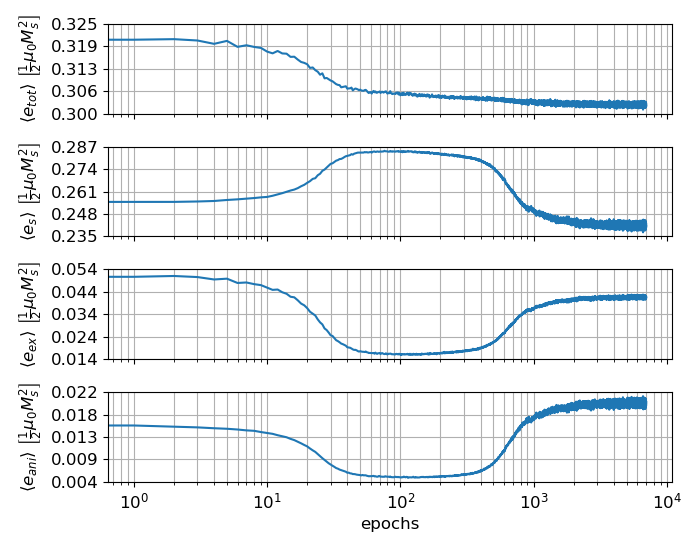

In [31]:
plots_flower = [
    Plot("$e_{tot}$", '$\\langle e_{tot}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_tot']),
    Plot("$e_s$", '$\\langle e_{s}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_mag']),
    Plot("$e_{ex}$", '$\\langle e_{ex}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_ex']),
    Plot("$e_{a}$", '$\\langle e_{ani}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_flower['e_ani']),
]

fig_flower = plot_hist(plots_flower)

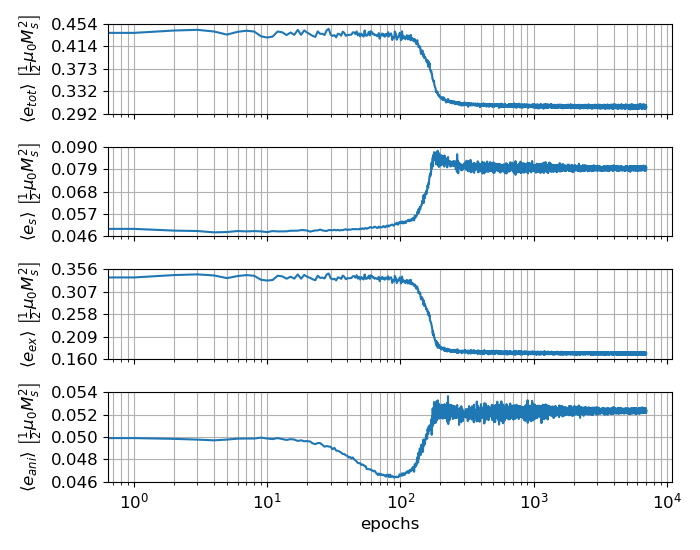

In [32]:
plots_vortex = [
    Plot("$e_{tot}$", '$\\langle e_{tot}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_tot']),
    Plot("$e_s$", '$\\langle e_{s}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_mag']),
    Plot("$e_{ex}$", '$\\langle e_{ex}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_ex']),
    Plot("$e_{a}$", '$\\langle e_{ani}\\rangle$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$', energies_vortex['e_ani']),
]

fig_vortex = plot_hist(plots_vortex)

In [16]:
_x_dom = array(Halton(3, seed=121).random(2**13))
_x_dom = domain.transform(_x_dom)
_x_tensor_dom = lax.map(lambda x: surface_tensors_grad(x, domain, 15, gauss5), _x_dom)

def _map(f):
    def _inner(*args):
        _f = lambda args: f(*args)
        return lax.map(_f, args)
    return _inner

def _exchange_energy(m, x, lam):
    A = 1 / (lam ** 2)
    def e_ex(x):
        dm = jacfwd(m)(x)
        return jnp.sum(dm * dm)
    return A * mean(vmap(e_ex)(x))

def _ani_energy(m, x):
    def e_ani(x):
        c = array([0., 0., 1.])
        return 1 - (m(x) @ c) ** 2

    return 0.1 * mean(vmap(e_ani)(x))

def _mag_energy(bs, m, x, xt):
    def e_mag(x, xt):
        e = lambda x: - dot(m(x), bs(x, xt))
        return e(x)

    return mean(vmap(e_mag)(x, xt))

@jit
def total_energy_flower(lam):
    lam = asarray(lam)
    m = lambda x: mag(m_flower, x, lam, params_flower)
    bs = stray_field_solver(m)
    e_ex = _exchange_energy(m, _x_dom, lam)
    e_ani = _ani_energy(m, _x_dom)
    e_mag = mag_energy(bs, m, _x_dom, _x_tensor_dom)
    # e_mag = (norm_m(m, _x_dom) + e_mag)
    e_mag = (1 + e_mag)
    e_tot = e_ex + e_ani + e_mag
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }

@jit
def total_energy_vortex(lam):
    lam = asarray(lam)
    m = lambda x: mag(m_vortex, x, lam, params_vortex)
    bs = stray_field_solver(m)
    e_ex = _exchange_energy(m, _x_dom, lam)
    e_ani = _ani_energy(m, _x_dom)
    e_mag = _mag_energy(bs, m, _x_dom, _x_tensor_dom)
    #e_mag = (norm_m(m, _x_dom) + e_mag)
    e_mag = (1 + e_mag)
    e_tot = e_ex + e_ani + e_mag
    return {
        'e_tot': e_tot,
        'e_mag': e_mag,
        'e_ex': e_ex,
        'e_ani': e_ani,
    }

# # @partial(jit, static_argnames=('mag0',))
# def total_energy(mag0, params, lam):
#     lam = asarray(lam)
#     m = lambda x: mag(mag0, x, lam, params)
#     bs = stray_field_solver(m)
#     e_ex = _exchange_energy(m, _x_dom, lam)
#     e_ani = _ani_energy(m, _x_dom)
#     e_mag = _mag_energy(bs, m, _x_dom, _x_tensor_dom)
#     # e_mag = (norm_m(m, _x_dom) + e_mag)
#     e_mag = (1 + e_mag)
#     e_tot = e_ex + e_ani + e_mag
#     return {
#         'e_tot': e_tot,
#         'e_mag': e_mag,
#         'e_ex': e_ex,
#         'e_ani': e_ani,
#     }
    
# def e(mag0, params, lam):
#     return total_energy(mag0, params, lam)['e_tot']

lam = jnp.arange(8, 9.01, 0.1)

In [17]:
_energies_flower = lax.map(total_energy_flower, lam)
_energies_vortex = lax.map(total_energy_vortex, lam)

2024-03-07 16:28:56.031221: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.314 = f32[8192,8,8,6,1]{4,3,2,1,0} slice(f32[8192,8,8,6,3]{4,3,2,1,0} %constant.565), slice={[0:8192], [0:8], [0:8], [0:6], [2:3]}, metadata={op_name="jit(scan)/jit(main)/while/body/jit(total_energy_flower)/vmap(jit(cross))/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1, 2, 3), collapsed_slice_dims=(4,), start_index_map=(4,)) slice_sizes=(8192, 8, 8, 6, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/tmp/ipykernel_12459/4010465120.py" source_line=35}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like 

In [18]:
import numpy as np
from scipy.optimize import bisect




def _e_flower(lam):
    return np.array(total_energy_flower(lam)["e_tot"])

def _e_vortex(lam):
    return np.array(total_energy_vortex(lam)["e_tot"])

def energy_difference(lam):
    vortex = _e_vortex(array(lam))
    flower = _e_flower(array(lam))
    return vortex - flower

cross_section = array(bisect(energy_difference, 8., 9.))
cross_section_energy = total_energy_flower(cross_section)["e_tot"]
cross_section

Array(8.561311, dtype=float32, weak_type=True)

In [21]:
def format_arr(a):
    a = np.array(a)
    a = np.round(a, 4)
    if len(a.shape) == 0:
        return f"{a:.4f}"
    return np.array_str(a, precision=4, suppress_small=True)

print(tree_map(format_arr, total_energy_flower(cross_section)))
print(tree_map(format_arr, total_energy_vortex(cross_section)))

{'e_ani': '0.0205', 'e_ex': '0.0421', 'e_mag': '0.2390', 'e_tot': '0.3017'}
{'e_ani': '0.0519', 'e_ex': '0.1707', 'e_mag': '0.0789', 'e_tot': '0.3016'}


In [22]:
def mean_mag(mag0, params, lam):
    def m(x):
        return mag(mag0, x, lam, params)
    return mean(vmap(m)(_x_dom), axis=0)
    

print("Mean Mag flower state: ", format_arr(mean_mag(m_flower, params_flower, cross_section)))
print("Mean Mag vortex state: ", format_arr(mean_mag(m_vortex, params_vortex, cross_section)))

Mean Mag flower state:  [0.0021 0.0076 0.8897]
Mean Mag vortex state:  [0.0007 0.3427 0.0025]


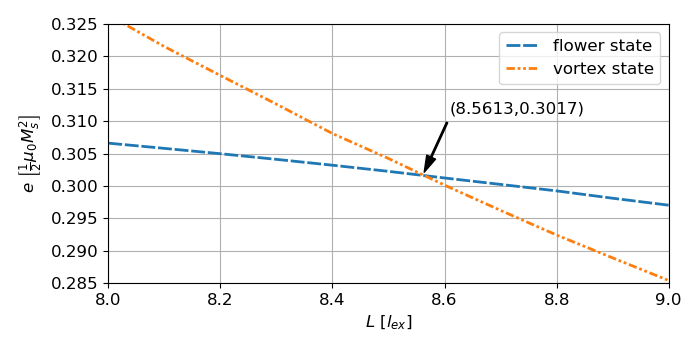

In [26]:
from matplotlib.ticker import FormatStrFormatter


fig = plt.figure(figsize=(7,3.5))


ax = fig.subplots(1,1)
ax.plot(lam, _energies_flower["e_tot"], linestyle=(0, (5, 1)), linewidth=2, label="flower state")
ax.plot(lam, _energies_vortex["e_tot"], linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2, label="vortex state")
ax.set_xlim((8., 9.))
ax.set_ylim((0.285, 0.325))
ax.legend()
ax.grid()
ax.set_xlabel("$L$ $\\left[l_{ex}\\right]$")
ax.set_ylabel("$e$ $\\left[\\frac{1}{2} \\mu_0 M_s^2\\right]$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
ax.tick_params(axis='both', which='major')

ax.annotate(f"({cross_section:.4f},{cross_section_energy:.4f})", xy=(cross_section,cross_section_energy),  xycoords='data',
            xytext=(0.85, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1,headwidth=7),
            horizontalalignment='right', verticalalignment='top', size=12
            )
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 9))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.tight_layout()

In [25]:
_energies_flower

{'e_ani': Array([0.01441683, 0.01541906, 0.01646365, 0.01754696, 0.01866515,
        0.01981428, 0.02099032, 0.02218917, 0.02340679, 0.02463914,
        0.02588228], dtype=float32),
 'e_ex': Array([0.03593127, 0.03700234, 0.0381001 , 0.03921505, 0.04033834,
        0.04146172, 0.04257764, 0.04367919, 0.04476012, 0.04581485,
        0.04683841], dtype=float32),
 'e_mag': Array([0.2562753 , 0.25339657, 0.25042957, 0.24735951, 0.24421334,
        0.24099451, 0.23768222, 0.23438847, 0.23109007, 0.22766995,
        0.22432983], dtype=float32),
 'e_tot': Array([0.3066234 , 0.30581796, 0.30499333, 0.30412152, 0.30321681,
        0.30227053, 0.3012502 , 0.30025685, 0.29925698, 0.29812396,
        0.29705054], dtype=float32)}